# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets


In [2]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases

,TM_A,TM_B,Decision
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
...,...,...,...
352,Lilton,Wilton,0
353,Nutricia,Nutritea,0
354,Glenreidh,An Reidhe,0
355,No Gunk No Junk,No Gunk Just Funk,0


In [3]:
import unidecode
from fuzzywuzzy import fuzz

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [4]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [5]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [6]:
from abydos.phones import *

In [7]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [8]:
import re

In [9]:
from tqdm import tqdm

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    return df

In [10]:

from itertools import combinations
import random
random.seed(30)

In [11]:
dftest=cases.loc[[2]]
dftest

,TM_A,TM_B,Decision
2,Zirco,Cozirc,1


In [12]:
tqdm.pandas()

df = featurize(cases)
df

/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 357/357 [00:00<00:00, 1130.52it/s]


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,pshp_soundex_first,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,Simoniz,Permanize,1,simoniz,permanize,57,50,50,0.658986,0,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,Magnavoc,Multivox,1,magnavoc,multivox,38,38,38,0.691532,0,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,Zirco,Cozirc,1,zirco,cozirc,89,73,73,0.806452,0,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,Platinum Puff,Platinum Plus,1,platinumpuff,platinumplus,83,83,83,0.895161,1,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,Maternity Yours,Your Maternity Shop,1,maternityyours,yourmaternityshop,74,65,65,0.743176,0,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Lilton,Wilton,0,lilton,wilton,83,83,83,0.943548,0,...,0.833333,0.833333,0.500000,0.833333,0.822222,0.833333,0.833333,0.866667,0.823529,0.943548
353,Nutricia,Nutritea,0,nutricia,nutritea,75,75,75,0.874552,1,...,0.833333,0.812500,0.565217,0.787500,0.833333,0.750000,0.750000,0.997549,0.937500,0.973790
354,Glenreidh,An Reidhe,0,glenreidh,anreidhe,80,71,71,0.498208,0,...,0.666667,0.666667,0.310345,0.666667,0.741402,0.588889,0.666667,0.784804,0.705882,0.655914
355,No Gunk No Junk,No Gunk Just Funk,0,nogunknojunk,nogunkjustfunk,67,77,77,0.822581,1,...,0.833333,0.678571,0.469388,0.700000,0.815873,0.637363,0.714286,0.995588,0.713415,0.808756


#### Export clean data to csv

In [ ]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [71]:
y = df.target
X = df.drop(columns = 'target')

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## TPOT AutoML pipeline

In [16]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

Load TPOT pipeline

In [80]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

,target,partial,tkn_sort,tkn_set,sum_ipa,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,1,57,50,50,0.658986,0,0.485480,0.388889,0.383752,0.000,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,1,38,38,38,0.691532,0,0.050000,0.437500,0.366778,0.125,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,1,89,73,73,0.806452,0,0.821263,0.583333,0.495199,0.000,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,1,83,83,83,0.895161,1,0.884677,0.833333,0.818487,0.750,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,1,74,65,65,0.743176,0,0.951613,0.588235,0.472052,0.000,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0,83,83,83,0.943548,0,0.897436,0.750000,0.796089,0.000,...,0.833333,0.833333,0.500000,0.833333,0.822222,0.833333,0.833333,0.866667,0.823529,0.943548
353,0,75,75,75,0.874552,1,0.804167,0.750000,0.798406,0.625,...,0.833333,0.812500,0.565217,0.787500,0.833333,0.750000,0.750000,0.997549,0.937500,0.973790
354,0,80,71,71,0.498208,0,0.800858,0.611111,0.510437,0.000,...,0.666667,0.666667,0.310345,0.666667,0.741402,0.588889,0.666667,0.784804,0.705882,0.655914
355,0,67,77,77,0.822581,1,0.852383,0.678571,0.700763,0.500,...,0.833333,0.678571,0.469388,0.700000,0.815873,0.637363,0.714286,0.995588,0.713415,0.808756


In [74]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [57]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3,
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

ValueError: could not convert string to float: 'CROWNE PLAZA'

In [75]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10,
                               min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)
results = exported_pipeline.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print(results)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [84]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [85]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    results = exported_pipeline.predict(X_test)
    
    return(results)

In [87]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

## K-fold cross validation

In [86]:
from sklearn.model_selection import StratifiedKFold

In [90]:
# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-90-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10


<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-90-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10


<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-90-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


<ipython-input-90-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-90-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()


In [91]:
meta_training.sample(10)

,TM_A,TM_B,predict_proba,target
302,cme,irsiacmi,1,0
246,horizon,horizonrisksolutions,1,1
75,realpetfoodcompany,therealpetfoodcompany,1,1
300,rives,rivers,1,0
295,fidelity,fideres,1,0
151,helloenergy,hellodiet,1,1
347,merano,murano,1,0
219,lifestyle,lifestylefloors,1,1
88,redinside,inside,1,1
329,pip,pipsisland,1,0


### Meta-Model: Logistic Regression

In [108]:
df= featurize(meta_training)

100%|██████████| 357/357 [00:00<00:00, 1103.16it/s]


In [110]:
df.head()

,a,b,predict_proba,target,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
2,zirco,cozirc,1,1,zirco,cozirc,89,73,73,0.806452,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
8,frickinchicken,flipnchicken,1,1,frickinchicken,flipnchicken,75,77,77,0.666667,...,0.666667,0.785714,0.500000,0.757143,0.782540,0.708791,0.642857,0.919118,0.758537,0.835253
12,kresco,cresco,1,1,kresco,cresco,83,83,83,1.000000,...,0.833333,0.916667,0.619048,0.983333,0.888889,0.833333,0.833333,0.874510,0.911765,0.994624
14,starbucks,sambucks,1,1,starbucks,sambucks,75,82,82,0.891129,...,0.666667,0.777778,0.676471,0.844444,0.884259,0.777778,0.777778,0.798039,0.709091,0.867384
45,zlide,logicslide,1,1,zlide,logicslide,80,53,53,0.673387,...,0.000000,0.450000,0.085714,0.550000,0.533333,0.254365,0.200000,0.762255,0.462963,0.496774


### Grid Search

In [111]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [113]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [115]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [116]:
scores_df = pd.DataFrame(scores)

In [117]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [118]:
scores_df.head()

,features,tn,fp,fn,tp
0,"('partial',)",0,13,0,59
1,"('tkn_sort',)",0,13,0,59
2,"('tkn_set',)",0,13,0,59
3,"('sum_ipa',)",0,13,0,59
4,"('pshp_soundex_first',)",0,13,0,59


In [119]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [120]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [122]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [123]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [124]:
print(grid_clf.best_params_)

{'C': 545.5594781168514}


## Evaluation

In [125]:
from sklearn.metrics import classification_report

In [126]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [127]:
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.86      1.00      0.93        62

    accuracy                           0.86        72
   macro avg       0.43      0.50      0.46        72
weighted avg       0.74      0.86      0.80        72

           Predicted: 0  Predicted: 1
Actual: 0             0            10
Actual: 1             0            62


/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.594')

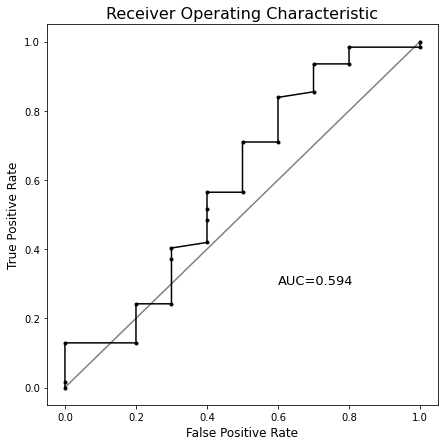

In [129]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(